# Lagged cross-covariance analysis

Resolution: 1-degree, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [10]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("white")

In [13]:
%load_ext autoreload
%autoreload 2

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to a regular grid and resample to monthly averages within each grid cell
df_sif_monthly = (
    utils.regrid(DS_sif, res=1)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    utils.regrid(DS_xco2, res=1)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lon", "lat", "time"], how="outer")
df_grid_monthly

,lon,lat,time,sif,xco2
0,-179.5,-85.5,2014-11-01,0.009041,NaN
1,-179.5,-85.5,2014-12-01,-0.119375,NaN
2,-179.5,-85.5,2015-01-01,NaN,NaN
3,-179.5,-85.5,2015-02-01,NaN,NaN
4,-179.5,-85.5,2015-03-01,NaN,NaN
...,...,...,...,...,...
1583238,167.5,-45.5,2020-06-01,NaN,NaN
1583239,167.5,-45.5,2020-07-01,NaN,410.175995
1583240,173.5,-35.5,2020-03-01,NaN,409.604797
1583241,173.5,-35.5,2020-04-01,NaN,NaN


In [6]:
# Convert to dataset and compute statistics
DS_grid_monthly = stats.get_stats(
    df_grid_monthly
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_grid_monthly["xcor_lag1"] = stats.apply_xcor(DS_grid_monthly.xco2, DS_grid_monthly.sif, lag=1)
DS_grid_monthly["xcor_lag2"] = stats.apply_xcor(DS_grid_monthly.xco2, DS_grid_monthly.sif, lag=2)

DS_grid_monthly

<xarray.Dataset>
Dimensions:     (lat: 165, lon: 360, time: 71)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -85.5 -84.5 -83.5 -82.5 ... 79.5 80.5 81.5 82.5
  * time        (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif         (lon, lat, time) float32 nan nan 0.009041228 ... nan nan nan
    xco2        (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    sif_count   (lon, lat) int64 11 18 18 17 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    xco2_count  (lon, lat) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    sif_slope   (lon, lat) float64 0.0004413 0.001662 0.002675 ... nan nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_std     (lon, lat) float64 0.0629 0.05758 0.1464 0.2423 ... nan nan nan
    xco2_std    (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag1   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag2   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan

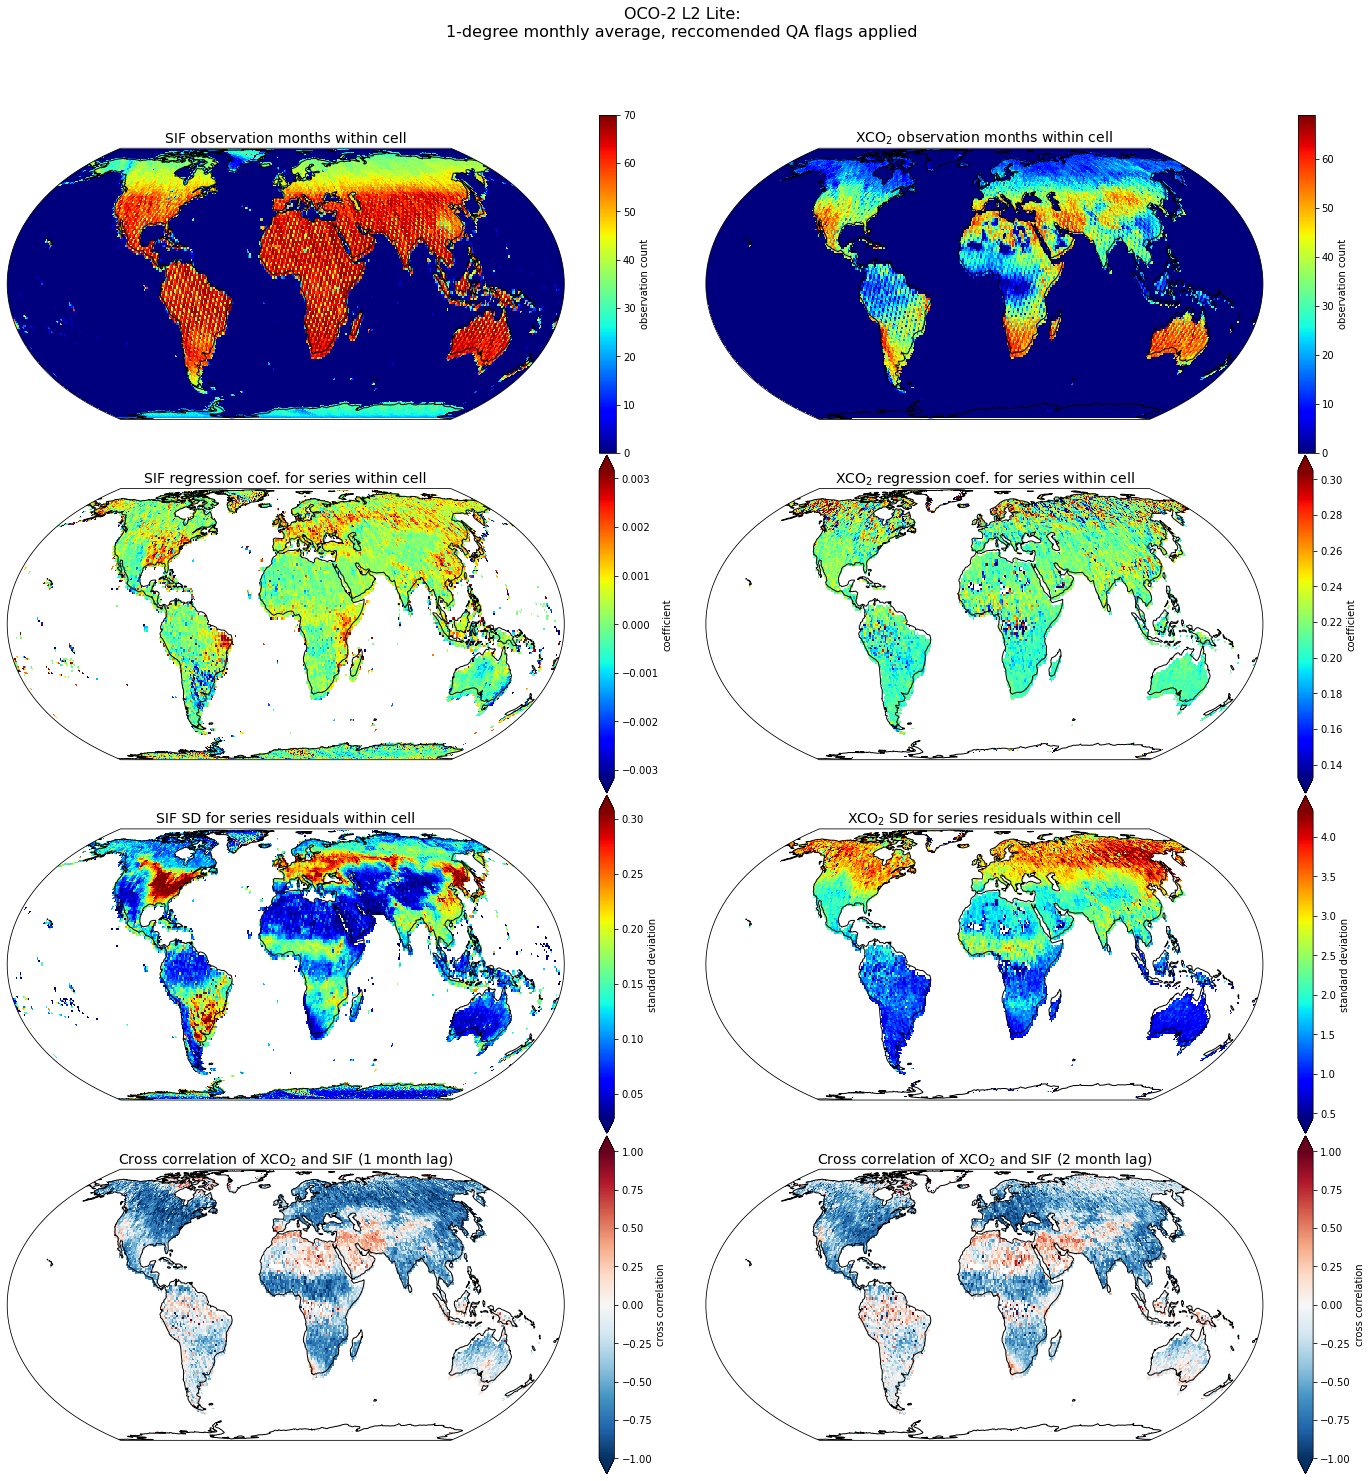

In [16]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "1-degree monthly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_count,
    title="SIF observation months within cell",
    ax=ax1,
    cbar_kwargs={"label": "observation count"},
    robust=False
)
plot.plot_da(
    DS_grid_monthly.xco2_count,
    title="XCO$_2$ observation months within cell",
    ax=ax2,
    cbar_kwargs={"label": "observation count"},
    robust=False
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_slope,
    title="SIF regression coef. for series within cell",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_monthly.xco2_slope,
    title="XCO$_2$ regression coef. for series within cell",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_std,
    title="SIF SD for series residuals within cell",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_monthly.xco2_std,
    title="XCO$_2$ SD for series residuals within cell",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (1 month lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_monthly.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (2 month lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/1deg_monthly_panel.png");